In [50]:
using Plots, Polynomials, Interpolations, DataFrames, Statistics

# Polynomials generation

In [51]:
x_lower_bound = 1
x_step = 1
x_upper_bound = 10
f1(x) = sin(3x - 10) / (1 + (x - 10)^2)
points = [(x, f1(x)) for x in x_lower_bound:x_step:x_upper_bound]

points_num = length(points)

function get_coords(points)
    x_coords = [x for (x, y) in points]
    y_coords = [y for (x, y) in points]
    return x_coords, y_coords
end
x_coords, y_coords = get_coords(points)

function plot_data_and_true(data_points, to_plot, f)
    x_coords, y_coords = get_coords(data_points)
    plot!(to_plot, [f(x) for x in to_plot], label="True Values")
    scatter!(x_coords, y_coords, label="Data points")
end

plot_data_and_true (generic function with 1 method)

In [52]:
function get_l(k, x, x_coords)
    output = 1
    xk = x_coords[k]
    for xi in x_coords
        if xi != xk
            output *= (x - xi) / (xk - xi)
        end
    end
    return output
end

function lagrange_pol_value(x, points)
    x_coords, y_coords = get_coords(points)
    output = 0
    for k in 1:length(x_coords)
        output += get_l(k, x, x_coords) * y_coords[k]
    end
    return output
end

lagrange_pol_value (generic function with 1 method)

In [53]:
# Nie wiem jak zrobic obiekt interpolacyjny wiec zrobilem cos na jego wyglad

function get_f!(lower_bound, upper_bound, points, f_values)
    if lower_bound == upper_bound
        return f_values[lower_bound, upper_bound]
    end
    
    x_coords, y_coords = get_coords(points)
    f_values[lower_bound, upper_bound] = get_f!(lower_bound + 1, upper_bound, points, f_values)
    
    denominator = f_values[lower_bound + 1, upper_bound]  - f_values[lower_bound, upper_bound - 1]
    numerator = x_coords[upper_bound] - x_coords[lower_bound]
    f_values[lower_bound, upper_bound] = denominator / numerator
    
    return f_values[lower_bound, upper_bound]
end

function get_f_values(points)
    points_num = length(points)
    f_values = Array{Float64}(undef, points_num, points_num)
    x_coords, y_coords = get_coords(points)
    for i in 1:points_num
        f_values[i, i] = y_coords[i]
    end
    
    for i in 2:points_num
        get_f!(1, i, points, f_values)
    end
    return f_values
end
    

function divided_diff(points)
    x_coords, y_coords = get_coords(points)
    points_num = length(x_coords)
    
    f_values = get_f_values(points) 
    
    function divided_diff_pol_value(x)
        output = y_coords[1]
        multiplier = x - x_coords[1]
        for i in 2:points_num
            output += f_values[1, i] * multiplier
            multiplier *= x - x_coords[i]
        end
        return output
    end
    return divided_diff_pol_value
end


divided_diff (generic function with 1 method)

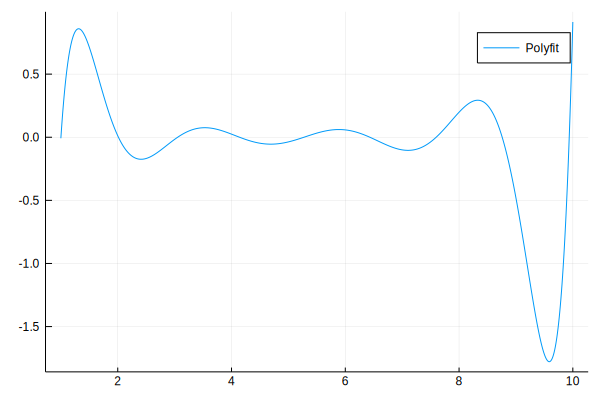

In [54]:
density = 0.01
to_plot = x_lower_bound:density:x_upper_bound

fit1 = polyfit(x_coords, y_coords)
plot(to_plot, [fit1(x) for x in to_plot], label="Polyfit")

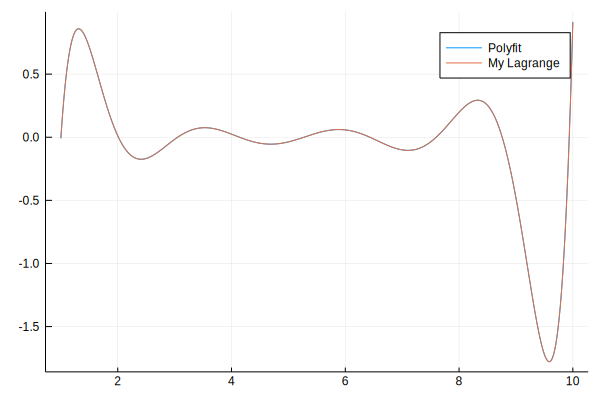

In [55]:
plot!(to_plot, [lagrange_pol_value(x, points) for x in to_plot], label="My Lagrange")

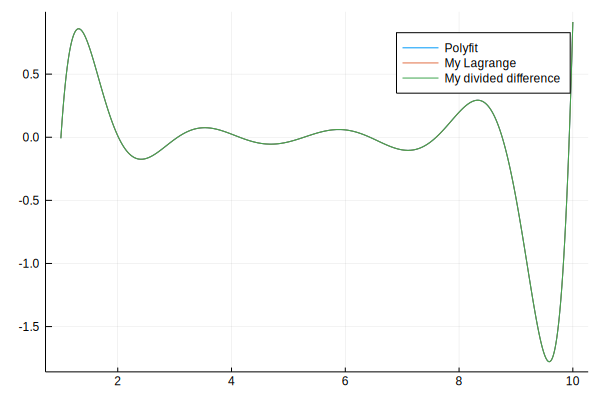

In [56]:
dd_fit = divided_diff(points)
plot!(to_plot, [dd_fit(x) for x in to_plot], label="My divided difference")

Every method constructs the same polynomial because polynomial of degree n - 1 is unambiguously defined by n points (except some degenarate when it isn't posible to construct polynomial)

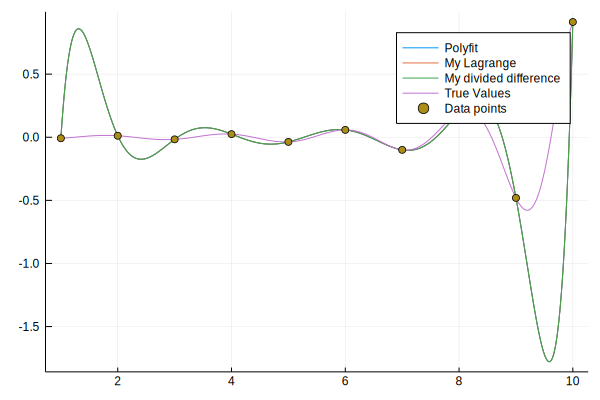

In [57]:
# how interpolation compares to real values
plot_data_and_true(points, to_plot, f1)

# Time testing

In [58]:
function get_polyfit_time(to_plot, points)
    x_coords, y_coords = get_coords(points)
    pre_time = @elapsed fit = polyfit(x_coords, y_coords)
    
    gen_time = @elapsed(
    for x in to_plot
        fit(x)
    end)
    return pre_time, gen_time
end

function get_lagrange_time(to_plot, points)
    gen_time =  @elapsed(
    for x in to_plot
        lagrange_pol_value(x, points)
    end)
    return 0.0, gen_time
end

function get_divided_diff_time(to_plot, points)
    pre_time = @elapsed dd_fit = divided_diff(points)
    
    gen_time = @elapsed(
    for x in to_plot
        dd_fit(x)
    end)
    return pre_time, gen_time
end

function get_times(samples_num, looping)
    measurements = DataFrame(Type_xCoords_toPlot = String[], Pre_time = Float64[], 
                             Gen_time = Float64[], Overall_time = Float64[])    

    for x_ub in looping
        to_plot = 1:(1/32):x_ub  # 1/32 to be precise in binary
        x_coords = 1:x_ub
        points = [(x, f1(x)) for x in x_coords]
        
        function push_times!(operation, times)
            pre_time, gen_time = times
            row = []
            push!(row, "$operation | $x_coords | $to_plot")
            push!(row, pre_time, gen_time, pre_time + gen_time)
            push!(measurements, row)
        end
        
        for i in 1:samples_num
            push_times!("Polyfit", get_polyfit_time(to_plot, points))
        end
        for i in 1:samples_num
            push_times!("Divided difference", get_divided_diff_time(to_plot, points))
        end
        for i in 1:samples_num
            push_times!("Lagrange", get_lagrange_time(to_plot, points))
        end
    end
    return measurements
end

function get_mean_and_std(measurements, samples_num)
    output = DataFrame(Type_xCoords_toPlot = String[], Pre_mean = Float64[], Gen_mean = Float64[],
                       Pre_std = Float64[], Gen_std = Float64[])
    rows_num = nrow(measurements)
    for i in 1:samples_num:rows_num
        samples = i:(i + samples_num - 1)
        operation = measurements[i, 1]
        pre_mean = mean(measurements[samples, 2])
        gen_mean = mean(measurements[samples, 3])
        pre_std = std(measurements[samples, 2])
        gen_std = std(measurements[samples, 3])
        row = [operation, pre_mean, gen_mean, pre_std, gen_std]
        push!(output, row)
    end
    return output
end

get_mean_and_std (generic function with 1 method)

In [59]:
looping_lb = 40
looping_s = 10
looping_ub = 100
looping = looping_lb:looping_s:looping_ub

samples_num = 10
measurements = get_times(samples_num, looping)
get_mean_and_std(measurements, samples_num)

,Type_xCoords_toPlot,Pre_mean,Gen_mean,Pre_std
,String,Float64,Float64,Float64
1,Polyfit | 1:40 | 1.0:0.03125:40.0,0.0009299,0.00010885,0.000698253
2,Divided difference | 1:40 | 1.0:0.03125:40.0,0.0003815,3.34703e-5,1.71158e-5
3,Lagrange | 1:40 | 1.0:0.03125:40.0,0.0,0.0104391,0.0
4,Polyfit | 1:50 | 1.0:0.03125:50.0,0.00186612,0.00019984,0.000654185
5,Divided difference | 1:50 | 1.0:0.03125:50.0,0.00064632,4.03203e-5,7.26233e-5
6,Lagrange | 1:50 | 1.0:0.03125:50.0,0.0,0.0144241,0.0
7,Polyfit | 1:60 | 1.0:0.03125:60.0,0.00183451,0.00024826,0.000868074
8,Divided difference | 1:60 | 1.0:0.03125:60.0,0.00114049,6.23403e-5,7.17776e-5
9,Lagrange | 1:60 | 1.0:0.03125:60.0,0.0,0.0271175,0.0


# Spline plots

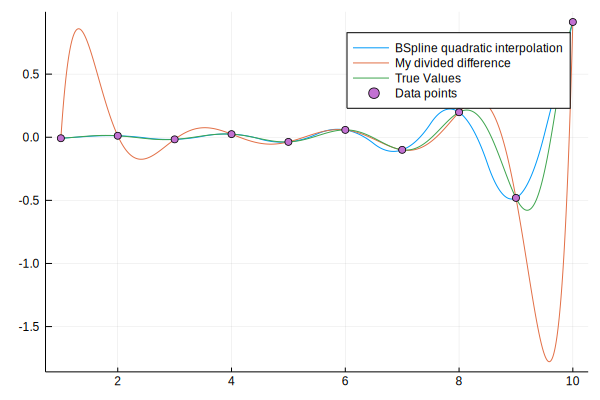

In [60]:
itp = interpolate(y_coords, BSpline(Quadratic(Line(OnCell()))))
y_spline = [itp(x) for x in to_plot]

plot(to_plot, y_spline, label="BSpline quadratic interpolation")

dd_fit = divided_diff(points)
plot!(to_plot, [dd_fit(x) for x in to_plot], label="My divided difference")

plot_data_and_true(points, to_plot, f1)

This is the same function the polynomial interpolation tried to approximate, we can see that in this example spline interpolation is much more accurate than polynomial, especailly on the begining and end where runge effect takes place

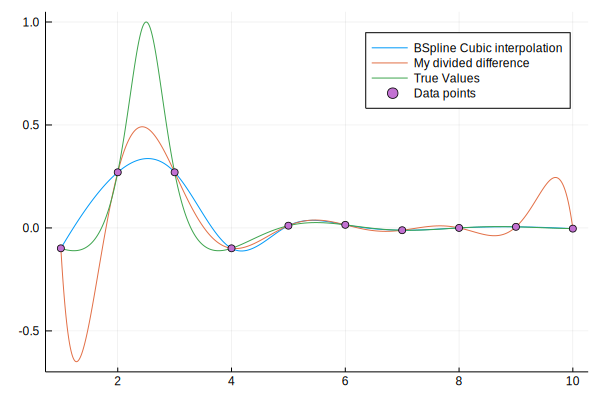

In [61]:
f2(x) = cos(2x - 5) / (1 + (2x - 5)^2)
points2 = [(x, f2(x)) for x in x_lower_bound:x_step:x_upper_bound]

x_coords2, y_coords2 = get_coords(points2)

itp = interpolate(y_coords2, BSpline(Cubic(Line(OnCell()))))
y_spline = [itp(x) for x in to_plot]
plot(to_plot, y_spline, label="BSpline Cubic interpolation")

dd_fit = divided_diff(points2)
plot!(to_plot, [dd_fit(x) for x in to_plot], label="My divided difference")

plot_data_and_true(points2, to_plot, f2)

# Runge effect

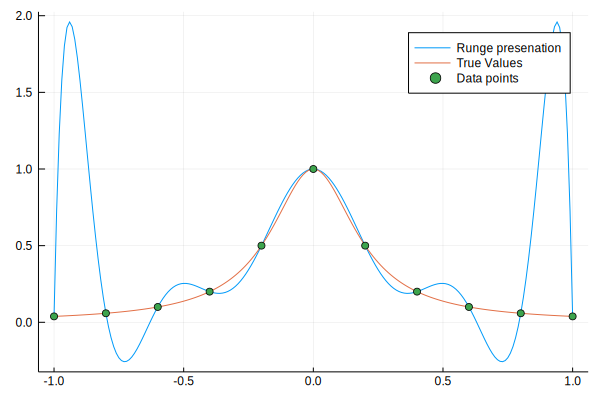

In [62]:
runge_xlb = -1
runge_s = 0.2
runge_xup = 1

runge_f(x) = 1 / (1 + 25 * x^2)
runge_p = [(x, runge_f(x)) for x in runge_xlb:runge_s:runge_xup]

runge_x, runge_y = get_coords(runge_p)

runge_fit = polyfit(runge_x, runge_y)

runge_tp = -1:0.01:1

plot(runge_tp, [runge_fit(x) for x in runge_tp], label="Runge presenation")
plot_data_and_true(runge_p, runge_tp, runge_f)